# Deconvolving simulated data generated with linear functions

In [1]:
import torch
from ternadecov.simulator import *
from ternadecov.time_deconv import *

# Configure

In [2]:
device = torch.device("cuda:0")
dtype = torch.float32
dtype_np = np.float32

# Load data

In [3]:
bulk_anndata_path = "/home/nbarkas/disk1/work/deconvolution_method/datasets/ebov/load_data_python/ebov_bulk.h5ad"
sc_anndata_path = "/home/nbarkas/disk1/work/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad"

In [4]:
with open(bulk_anndata_path, 'rb') as fh:
    bulk_anndata  = anndata.read_h5ad(fh)
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [5]:
# select samples only after or on tp 0
bulk_anndata = bulk_anndata[bulk_anndata.obs['dpi_time'] >= 0,]

In [6]:
ebov_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = bulk_anndata,
    bulk_time_col = "dpi_time",
    dtype_np = dtype_np,
    dtype = dtype,
    device=device,
    feature_selection_method = 'overdispersed_bulk_and_high_sc' #'overdispersed_bulk'
)

/home/nbarkas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.1044e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


3356 genes selected


# Run Deconvolution

In [7]:
pseudo_time_reg_deconv = TimeRegularizedDeconvolution(
    dataset=ebov_dataset,
    polynomial_degree = 5,
    basis_functions = "polynomial",
    device=device,
    dtype=dtype)

In [8]:
pseudo_time_reg_deconv.fit_model(n_iters=5_001, verbose=True, log_frequency=1000)

[step: 0, time: 1 s ] loss: 30365559.04
[step: 1000, time: 11 s ] loss: 8949856.39
[step: 2000, time: 21 s ] loss: 3629082.94
[step: 3000, time: 31 s ] loss: 2064470.72
[step: 4000, time: 41 s ] loss: 1487620.27
[step: 5000, time: 51 s ] loss: 1227565.80


# Examine Outputs

<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

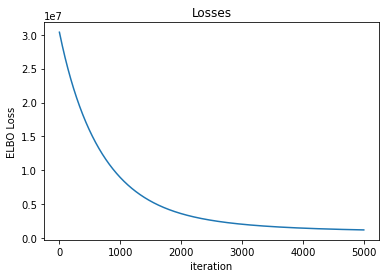

In [9]:
# plot the losses
pseudo_time_reg_deconv.plot_loss()

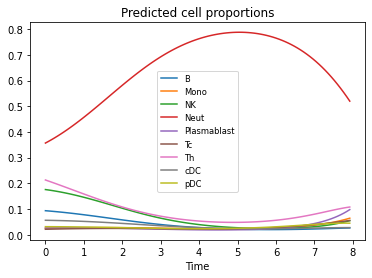

In [10]:
# calculate and plot composition trajectories
#pseudo_time_reg_deconv.calculate_composition_trajectories(n_intervals = 1000)
pseudo_time_reg_deconv.plot_composition_trajectories()

<AxesSubplot:xlabel='$\\phi_g$', ylabel='Counts'>

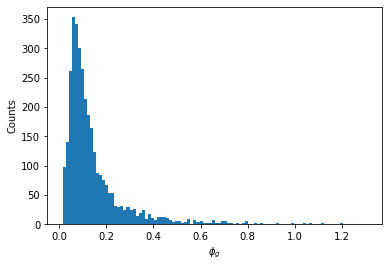

In [11]:
# examine the per-gene dispersions
pseudo_time_reg_deconv.plot_phi_g_distribution()

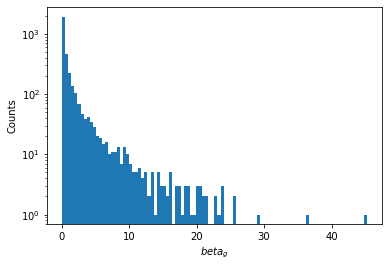

In [12]:
# examine the gene capture coefficients
pseudo_time_reg_deconv.plot_beta_g_distribution()
matplotlib.pyplot.yscale('log')

# Simulation

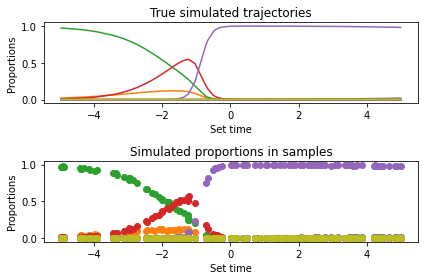

In [13]:
# Simulate and plot 100 samples from a random trajectory 
# based on linear functions through a softmax

sim_res = simulate_data(
    w_hat_gc = torch.Tensor(pseudo_time_reg_deconv.dataset.w_hat_gc),
    num_samples=100, 
    trajectory_type='linear')

plot_simulated_proportions(sim_res)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [14]:
# Generate input AnnData object from the above simulation
simulated_bulk = generate_anndata_from_sim(
    sim_res, 
    reference_deconvolution = pseudo_time_reg_deconv)

# Generate a deconvolution dataset
ebov_simulated_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = simulated_bulk,
    bulk_time_col = "time",
    dtype_np = dtype_np,
    dtype = dtype,
    device = device,
    feature_selection_method = 'common' 
)

TypeError: generate_anndata_from_sim() got an unexpected keyword argument 'reference_deconvolution'

In [ ]:
# Set-up and run the deconvolution
pseudo_time_reg_deconv_sim = TimeRegularizedDeconvolution(
    dataset=ebov_simulated_dataset,
    polynomial_degree = 20,
    basis_functions = "polynomial",
    device=device,
    dtype=dtype)

pseudo_time_reg_deconv_sim.fit_model(
    n_iters=5_001, 
    verbose=True, 
    log_frequency=1000
)

# Examine Outputs

In [ ]:
pseudo_time_reg_deconv_sim.plot_loss()

In [ ]:
pseudo_time_reg_deconv_sim.calculate_composition_trajectories(n_intervals = 1000)
pseudo_time_reg_deconv_sim.plot_composition_trajectories()

In [ ]:
# examine the per-gene dispersions
pseudo_time_reg_deconv.plot_phi_g_distribution()

In [ ]:
# examine the gene capture coefficients
pseudo_time_reg_deconv.plot_beta_g_distribution()
matplotlib.pyplot.yscale('log')

In [ ]:
# examine the alphas

alphas = list(pseudo_time_reg_deconv.param_store_hist[i]['dirichlet_alpha'] for i in range(len(pseudo_time_reg_deconv.param_store_hist)))

fig, ax = matplotlib.pyplot.subplots(1,2)

ax[0].plot(alphas)
ax[0].set_title(r'Dirichlet $ \alpha $ Values')

ax[1].plot(alphas[-500:])
ax[1].set_title(r'Last few Dirichlet $ \alpha $ Values')

## Evaluate with variable alpha

In [ ]:
alpha_vals = list(10**(x -1 ) for x in range(4)) 
alpha_vals

In [ ]:
# Use a single trajectory for all iterations
trajectory_coef = sample_linear_trajectories(num_cell_types = pseudo_time_reg_deconv.w_hat_gc.shape[1])

In [ ]:
df_a = []
l1_error = []

for a in alpha_vals:
    sim_res = simulate_data(
        num_samples=100, 
        w_hat_gc = torch.Tensor(pseudo_time_reg_deconv.dataset.w_hat_gc),
        trajectory_type='linear', 
        dirichlet_alpha = a,
        trajectory_coef = trajectory_coef
    )
    
    plot_simulated_proportions(sim_res)
    
    simulated_bulk = generate_anndata_from_sim(sim_res, reference_deconvolution=pseudo_time_reg_deconv)
    
    ebov_simulated_dataset = DeconvolutionDataset(
        sc_anndata = sc_anndata,
        sc_celltype_col = "Subclustering_reduced",
        bulk_anndata = simulated_bulk,
        bulk_time_col = "time",
        dtype_np = dtype_np,
        dtype = dtype,
        device = device,
        feature_selection_method = 'common' 
    )
    
    pseudo_time_reg_deconv_sim = TimeRegularizedDeconvolution(
        dataset=ebov_simulated_dataset,
        polynomial_degree = 3,
        basis_functions = "polynomial",
        device=device,
        dtype=dtype)
    
    pseudo_time_reg_deconv_sim.fit_model(n_iters=5_001, verbose=True, log_frequency=1000)
    
    errors = calculate_trajectory_prediction_error(sim_res, pseudo_time_reg_deconv_sim)
    df_a.append(a)
    l1_error.append(errors['L1_error_norm'])
    
    pseudo_time_reg_deconv_sim.plot_composition_trajectories()